<a href="https://colab.research.google.com/github/hannahzafar/UMDAOSC650/blob/main/FinalProject_Zafar.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [192]:
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
import pandas as pd
import sklearn
from sklearn.preprocessing import MinMaxScaler
import keras
from keras.src.preprocessing.sequence import TimeseriesGenerator
from keras import layers
# from keras.models import Sequential
# from keras.layers import LSTM, Dense, Dropout, Activation, TimeDistributed, RepeatVector

In [193]:
keras.utils.set_random_seed(812)

**Part A: Data Preprocessing**

In [194]:
# Import data saved to Github
# This dataset includes ~200 years of a "perpetual 2000" (consistently at year 2000 scenario) run from the model GEOS-S2S.
# Data is aggregated for NH polar region: SLP_N, SNO_N, TS_N = sea level pressure, snowfall, and skin temperature averaged from 60-90 N.
# Extent_Had_Diff_N = Difference between modeled NH sea ice extent and average HadISST2 (monthly mean sea ice extent) for 1990-2010.
url_data = 'https://raw.githubusercontent.com/hannahzafar/UMDAOSC650/main/preprocessed_NN_data.csv'
dataset = pd.read_csv(url_data,index_col=0, parse_dates=True)
dataset.head()
dataset.tail()

,SLP_N,SNO_N,TS_N,Extent_Had_Diff_N
time,,,,
2214-08-01,101027.766,0.000004,276.81607,-3.017685
2214-09-01,100945.914,0.000009,271.55286,-2.241334
2214-10-01,100826.220,0.000012,263.31000,-3.099138
2214-11-01,101244.210,0.000010,253.28346,-3.758412
2214-12-01,101192.510,0.000009,249.69000,-4.335911


In [195]:
# Check for NaN's
dataset.isnull().any()

SLP_N                False
SNO_N                False
TS_N                 False
Extent_Had_Diff_N    False
dtype: bool

In [196]:
# Get basic info on data
dataset.describe()

,SLP_N,SNO_N,TS_N,Extent_Had_Diff_N
count,2340.000000,2340.000000,2340.000000,2340.000000
mean,101372.791455,0.000008,261.423434,-3.486153
std,444.645150,0.000002,11.544250,0.947182
min,100131.240000,0.000001,242.590670,-5.551069
25%,101047.282500,0.000006,249.892100,-4.201290
50%,101307.620000,0.000008,259.897575,-3.496218
75%,101642.403750,0.000009,273.126955,-2.844680
max,103051.740000,0.000013,278.619300,-0.592718


Text(0.5, 1.0, 'NH Sea Ice Extent Deviation from Reanalysis')

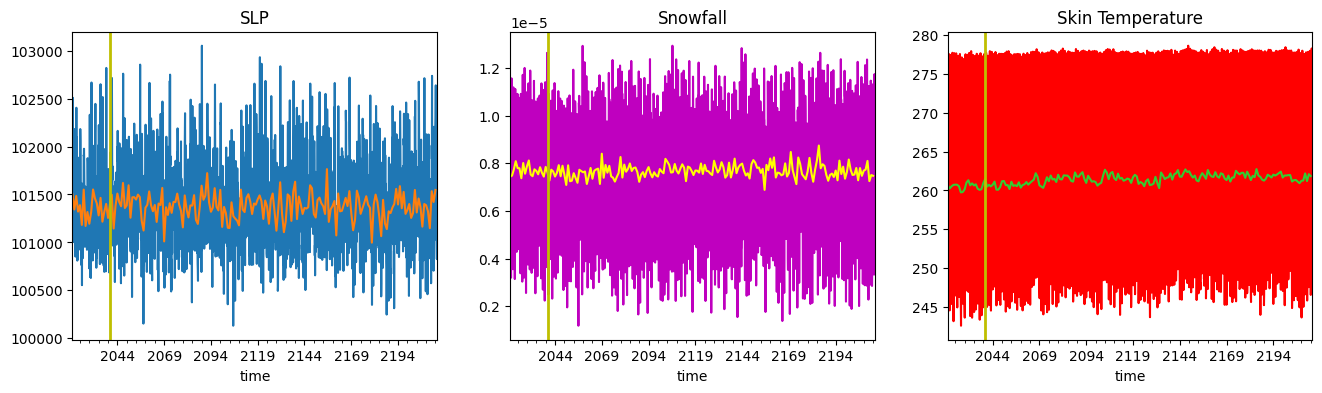

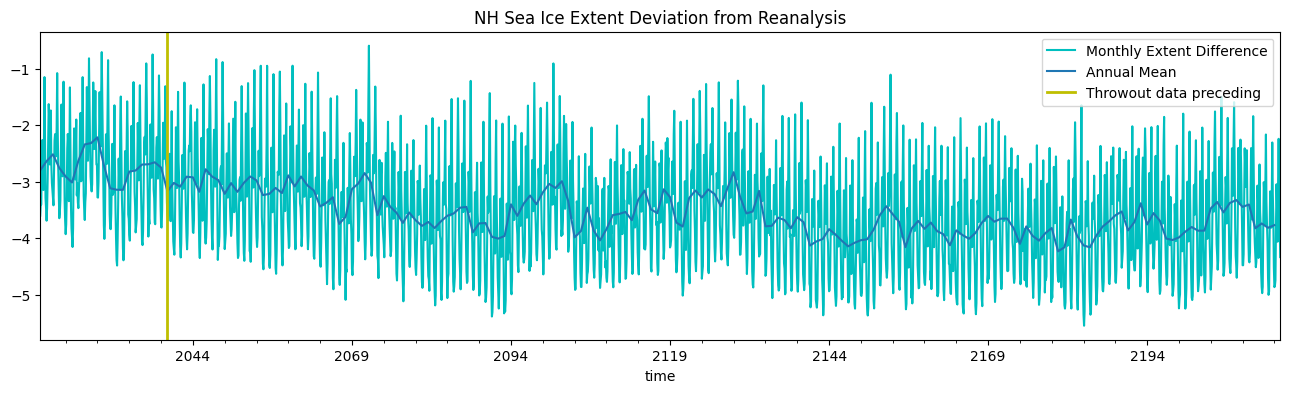

In [197]:

fig, ax = plt.subplots(1,3,figsize=(16,4))

dataset["SLP_N"].plot(ax=ax[0])
dataset["SLP_N"].groupby(pd.Grouper(freq='1Y')).mean().plot(ax=ax[0],label='Annual Mean')
ax[0].set_title('SLP')

dataset["SNO_N"].plot(ax=ax[1],c='m')
dataset["SNO_N"].groupby(pd.Grouper(freq='1Y')).mean().plot(ax=ax[1],label='Annual Mean',c='yellow')
ax[1].set_title('Snowfall')

dataset["TS_N"].plot(ax=ax[2],c='r')
dataset["TS_N"].groupby(pd.Grouper(freq='1Y')).mean().plot(ax=ax[2],label='Annual Mean',c='limegreen')
ax[2].set_title('Skin Temperature')

for axis in ax:
  axis.axvline(dt.date(2040,1,1),color='y',lw=2)

fig, ax = plt.subplots(1,1,figsize=(16,4))
dataset["Extent_Had_Diff_N"].plot(ax=ax,c='c',label='Monthly Extent Difference')
dataset["Extent_Had_Diff_N"].groupby(pd.Grouper(freq='1Y')).mean().plot(ax=ax,label='Annual Mean')
ax.axvline(dt.date(2040,1,1),color='y',lw=2, label='Throwout data preceding')
plt.legend()
ax.set_title('NH Sea Ice Extent Deviation from Reanalysis')

In [198]:
# Drop data
# (Already dropped first 5 years prior to upload, but will drop another 20 for model to reach error saturation based on above plots):
dataset = dataset[dataset.index.year>=2040]
print(dataset)

                 SLP_N     SNO_N       TS_N  Extent_Had_Diff_N
time                                                          
2040-01-01  101413.445  0.000008  247.76111          -3.589388
2040-02-01  101425.410  0.000008  246.89932          -3.680192
2040-03-01  101501.280  0.000008  249.72623          -3.384821
2040-04-01  101938.055  0.000009  257.18585          -2.991412
2040-05-01  101870.980  0.000008  269.11966          -2.506895
...                ...       ...        ...                ...
2214-08-01  101027.766  0.000004  276.81607          -3.017685
2214-09-01  100945.914  0.000009  271.55286          -2.241334
2214-10-01  100826.220  0.000012  263.31000          -3.099138
2214-11-01  101244.210  0.000010  253.28346          -3.758412
2214-12-01  101192.510  0.000009  249.69000          -4.335911

[2100 rows x 4 columns]


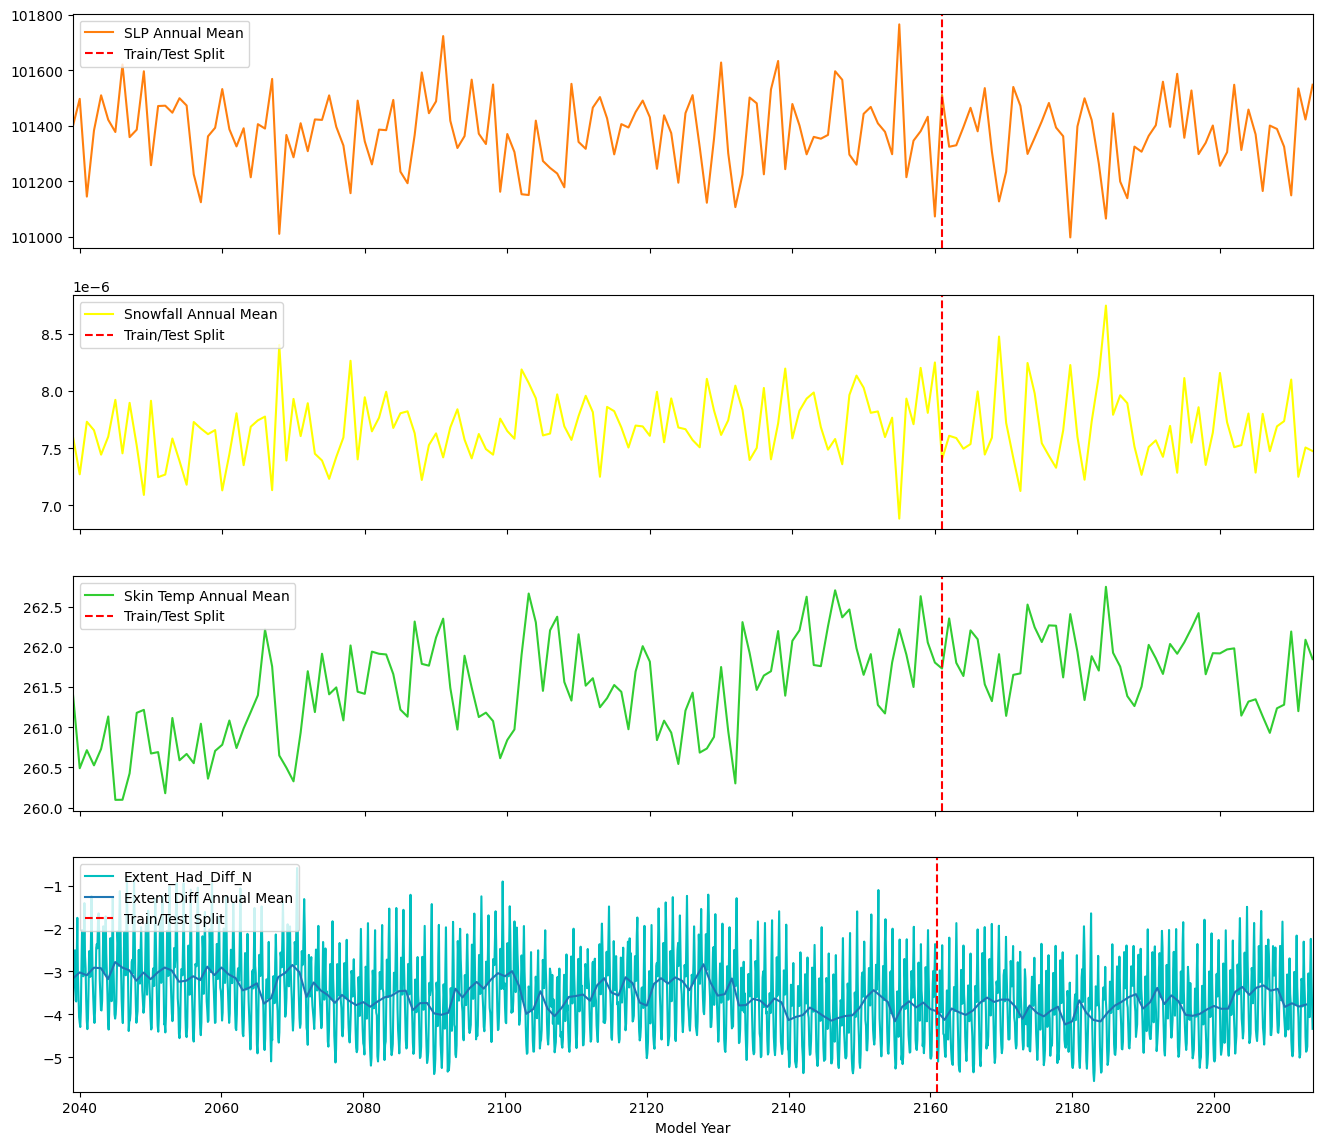

In [199]:
fig, ax = plt.subplots(4,1,figsize=(16,14))
dataset["SLP_N"].groupby(pd.Grouper(freq='1Y')).mean().plot(ax=ax[0],label='SLP Annual Mean',color='tab:orange')
dataset["SNO_N"].groupby(pd.Grouper(freq='1Y')).mean().plot(ax=ax[1],label='Snowfall Annual Mean',c='yellow')
dataset["TS_N"].groupby(pd.Grouper(freq='1Y')).mean().plot(ax=ax[2],label='Skin Temp Annual Mean',c='limegreen')
dataset["Extent_Had_Diff_N"].plot(ax=ax[3],c='c')
dataset["Extent_Had_Diff_N"].groupby(pd.Grouper(freq='1Y')).mean().plot(ax=ax[3],label='Extent Diff Annual Mean',sharex=True)
for axis in ax:
  axis.axvline(dt.date(2162,1,1),color='r',ls='dashed',label='Train/Test Split')
  axis.legend(loc='upper left')
  axis.set_xlabel('Model Year')
  axis.set_xticks([])
  axis.set_xticks([],minor=True)
  axis.set_xticks(pd.date_range(start='12/31/2040',end='12/31/2220',freq='20YS'))
  axis.set_xticklabels(np.arange(2040,2220,20))

In [200]:
dataset["SLP_N"].groupby(pd.Grouper(freq='1Y')).mean()

time
2040-12-31    101394.211667
2041-12-31    101496.724083
2042-12-31    101144.814583
2043-12-31    101382.877417
2044-12-31    101509.464583
                  ...      
2210-12-31    101324.496250
2211-12-31    101149.203000
2212-12-31    101534.225500
2213-12-31    101422.360417
2214-12-31    101547.519583
Freq: A-DEC, Name: SLP_N, Length: 175, dtype: float64

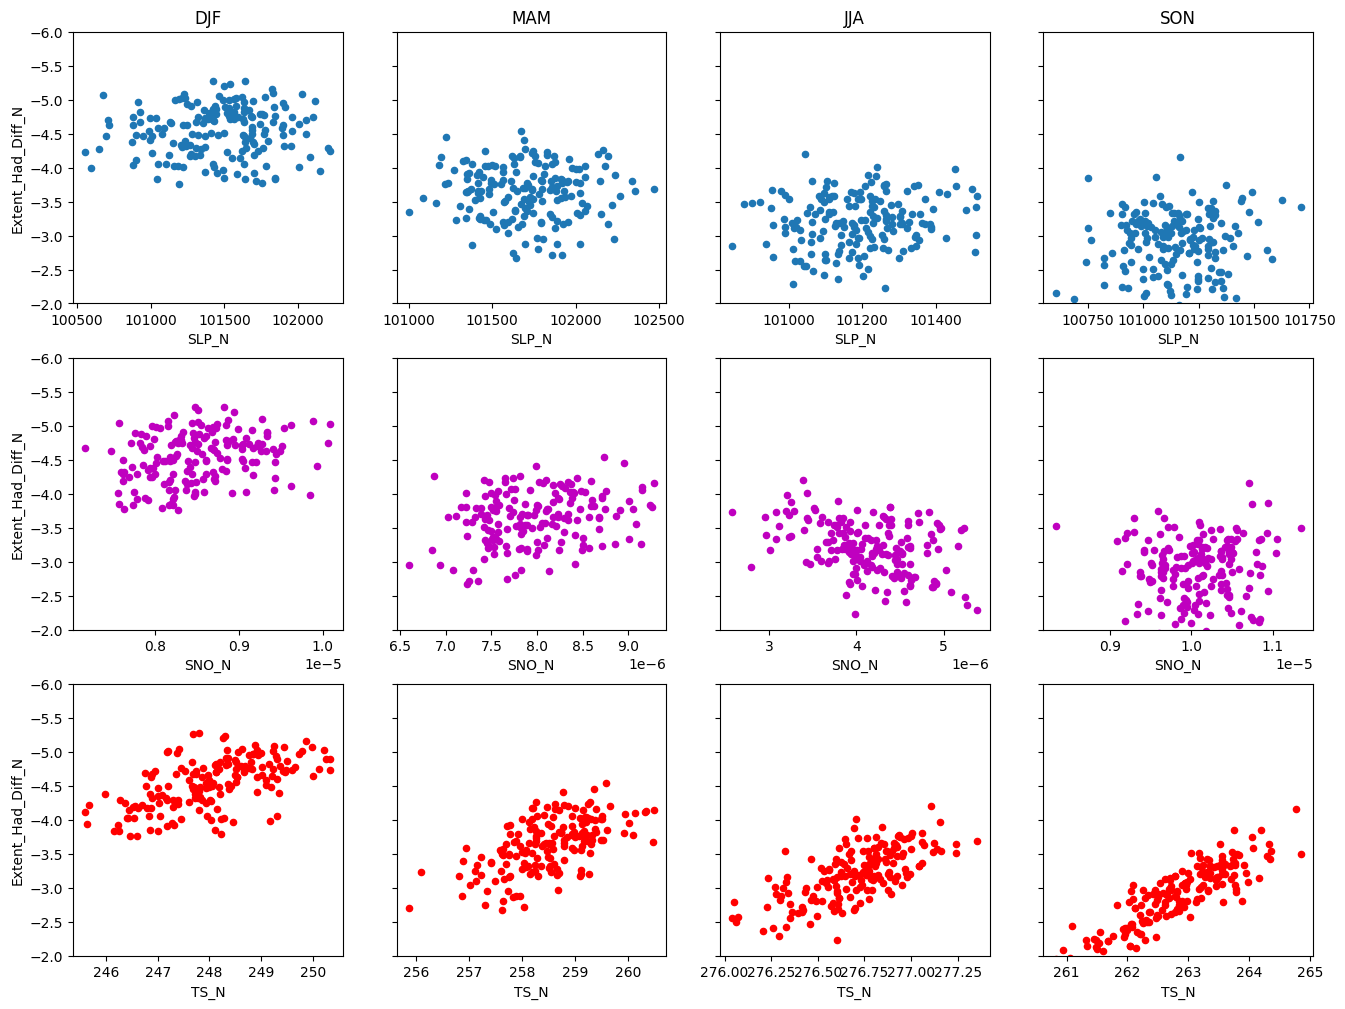

In [201]:
# Visualize seasonal data: DJF, MAM, JJA, SON
dataset_season = dataset.rolling(3,min_periods=3,center=True).mean()

seasons = ['DJF', 'MAM', 'JJA', 'SON']
month = [1,4,7,10]

fig, ax = plt.subplots(3,4,figsize=(16,12))

for i,(sea,mon) in enumerate(zip(seasons,month)):
  dataset_sea_sel = dataset_season[dataset.index.month==mon]
  dataset_sea_sel.plot.scatter("SLP_N","Extent_Had_Diff_N",ax=ax[0,i],sharey=True)
  dataset_sea_sel.plot.scatter("SNO_N","Extent_Had_Diff_N",ax=ax[1,i],c='m',sharey=True)
  dataset_sea_sel.plot.scatter("TS_N","Extent_Had_Diff_N",ax=ax[2,i],c='r',sharey=True)
  ax[0,i].set_title(f'{sea}')
  for j in range(3):
    ax[j,i].set_ylim([-2,-6])

**Part B: Train Dataset**

In [223]:
# Because time series data, define split points manually
# Split function
def split_time_series(data, train_ratio=0.7, val_ratio=0.1):
    total_len = len(data)
    train_len = int(total_len * train_ratio/12)*12 # Keep years together
    val_len = int(total_len * val_ratio/12)*12 # Keep years together
    test_len = total_len - train_len - val_len

    train_data = data[:train_len]
    val_data = data[train_len:train_len + val_len]
    test_data = data[train_len + val_len:]

    return train_data, val_data, test_data

In [226]:
trainds, valds, testds = split_time_series(dataset)
print(trainds.shape, valds.shape,testds.shape)

(1464, 4) (204, 4) (432, 4)


In [214]:
# OLD
# print(dataset.shape)
# split = round((dataset.index.year[-1] - dataset.index.year[0])*0.7)
# train_end = split + dataset.index.year[0]
# print(f'Train start: {dataset.index.year[0]} \t Train End: {train_end}')
# trainds = dataset[dataset.index.year<=dataset.index.year[0]+split]
# testds = dataset[dataset.index.year>dataset.index.year[0]+split]
# # print(trainds.index[0], trainds.index[-1], testds.index[0], testds.index[-1],sep=', ')
# print(trainds.shape, testds.shape)

In [222]:
# Remove time index
trainds = trainds.reset_index(drop=True)
valds = valds.reset_index(drop=True)
testds = testds.reset_index(drop=True)

In [187]:
# Feature Scaling
scaler = MinMaxScaler(feature_range=(0,1))

# Rescale train + test
trainds_scaled = scaler.fit_transform(trainds)
testds_scaled = scaler.transform(testds)
print(trainds_scaled, testds_scaled,  sep='\n\n')

# Test scaling was done by columns only
print(max(trainds_scaled[:,0]),max(trainds_scaled[:,1]),max(trainds_scaled[:,2]),max(trainds_scaled[:,3]))

[[0.43903612 0.57218529 0.11664138 0.37507713]
 [0.44313303 0.55187321 0.09197144 0.35614096]
 [0.46911145 0.60464378 0.17289567 0.41773723]
 ...
 [0.30217086 0.77781524 0.56224952 0.3572571 ]
 [0.49982537 0.71715011 0.30664104 0.19457303]
 [0.39960623 0.63547476 0.18420882 0.19163444]]

[[0.19968841 0.67662736 0.13263752 0.13259022]
 [0.32874508 0.75358383 0.18031306 0.08538899]
 [0.45518233 0.74169321 0.29089165 0.08323483]
 ...
 [0.2379661  0.89866359 0.56174999 0.47731335]
 [0.38108885 0.73547858 0.27472633 0.33982903]
 [0.36338641 0.66819926 0.17185854 0.21939777]]
1.0 1.0 1.0 1.0


In [190]:
# Extract input data
input_test = trainds_scaled[:,:3]
input_test.shape

(1476, 3)

In [191]:
# Extract target output
target_test = trainds_scaled[:,-1].reshape(-1,1)
target_test.shape

(1476, 1)

In [241]:
# Create a Time Series Generator
data = input_test
target = target_test

n_input = 5 #Sea ice persistence of 1-5 months?
n_features = data.shape[1]

# Time series generator
data_gen = TimeseriesGenerator(data,
                               target,
                               length=n_input,
                               sampling_rate=1,
                               batch_size=16, # you can try different batch sizes
                               shuffle=True)

In [246]:
len(data_gen[:10])

2

In [229]:
for da in data_gen:
  print(da[0].shape)
  print(da[1].shape)
  break

(16, 5, 3)
(16, 1)


In [83]:
# Double check shapes
print(data.shape, target.shape, n_features)

(1236, 3) (1236, 1) 3


In [84]:
# Double check output
batch_0 = data_gen[0]
x, y = batch_0
print(x[0], y[0])
print(x.shape, y.shape)

[[0.42300291 0.71523294 0.2454814 ]
 [0.35256634 0.5835643  0.06868818]
 [0.49431947 0.56226476 0.05517823]
 [0.3103989  0.70130333 0.21399946]
 [0.41220681 0.58503053 0.4077923 ]] [0.50050098]
(16, 5, 3) (16, 1)


In [230]:
# Create Many to One LSTM
regressor = keras.Sequential()
regressor.add(keras.layers.Input(shape=(1, n_features)))

# units are nodes
regressor.add(keras.layers.LSTM(units=100, return_sequences=False)) # FALSE = many to one

# hidden layers
#regressor.add(keras.layers.Dense(units=8,activation=keras.activations.relu))
#regressor.add(keras.layers.Dense(units=8,activation=keras.activations.relu))

# one neuron for output prediction
regressor.add(keras.layers.Dense(units=1))
regressor.add(keras.layers.Activation(activation=keras.activations.linear))

# compile model
regressor.compile(optimizer='adam', loss='mean_squared_error', metrics=['mse', 'mae'])

# what does graph look like?
regressor.summary()

Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_14 (LSTM)              (None, 1)                 20        
                                                                 
 dense_37 (Dense)            (None, 1)                 2         
                                                                 
 activation_7 (Activation)   (None, 1)                 0         
                                                                 
Total params: 22 (88.00 Byte)
Trainable params: 22 (88.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [247]:
# Train LSTM
history = regressor.fit(
    data_gen,
    epochs=20,
    validation_data=data_gen)
    # validation_split=0.1

Epoch 1/20
92/92 [==============================] - 3s 29ms/step - loss: 0.0224 - mse: 0.0224 - mae: 0.1232 - val_loss: 0.0234 - val_mse: 0.0234 - val_mae: 0.1263
Epoch 2/20
92/92 [==============================] - 1s 16ms/step - loss: 0.0224 - mse: 0.0224 - mae: 0.1228 - val_loss: 0.0215 - val_mse: 0.0215 - val_mae: 0.1210
Epoch 3/20
92/92 [==============================] - 1s 16ms/step - loss: 0.0222 - mse: 0.0222 - mae: 0.1218 - val_loss: 0.0214 - val_mse: 0.0214 - val_mae: 0.1203
Epoch 4/20
92/92 [==============================] - 2s 20ms/step - loss: 0.0220 - mse: 0.0220 - mae: 0.1216 - val_loss: 0.0217 - val_mse: 0.0217 - val_mae: 0.1210
Epoch 5/20
28/92 [========>.....................] - ETA: 0s - loss: 0.0210 - mse: 0.0210 - mae: 0.1204

KeyboardInterrupt: 

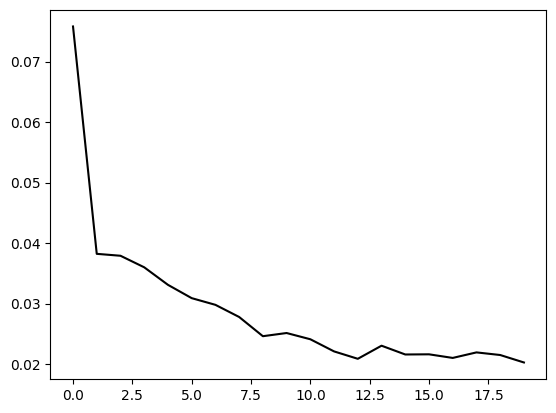

In [88]:
# Plot loss curves
plt.plot(range(0,20), history.history['loss'], c='k')
# plt.plot(range(0,25), history.history['val_loss'], c='r')
plt.show()